In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import optimize
import plotly.graph_objs as go
import corner
import emcee
from IPython.display import display, Math

In [2]:
def Fermi_function(Z, kinetic_energy):
    me = 0.511*1000 #keV
    a = 1/137
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    x = 2*np.pi*Z*a*E/pc
    return x/(1-np.exp(-x))

In [198]:
def B(x, k, i, t):
    """
    B-spline
    t : numpy array
      knots
    k, i : int
      spline number
    return: B_ki spline at point x
    """
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2



def T(x, x_knots, b):
    """
    time strategy
    x_knots : numpy array
    b : numpy array
      weights
    return: time at point x
    """
    t = x_knots
    T = 1e-19
    for i in range(1, len(t)-5):
        T += b[i-1]*B(x, 3, i, t)
    
    return T*3*3600*24*365 #3 years

In [29]:
def experiment(kinetic_energy, max_energy, noise, calibr, m, U, lin, Z=2, me=511):
    """
    function for fitting with linear additive
    """
    return calibr*intensity(kinetic_energy, max_energy, m, U, lin) + noise 

def intensity(kinetic_energy, max_energy, m, U, lin, Z=2, me=511):
    """
    function for intensity with linear additive
    """
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    return Fermi_function(Z, kinetic_energy) * (kinetic_energy + me) *pc*(max_energy - kinetic_energy)* (U**2*np.sqrt((max_energy - kinetic_energy)**2 - m**2) + (1 - U**2)*(max_energy - kinetic_energy)) - lin*(max_energy - kinetic_energy)

In [254]:
def div_max(kinetic_energy, max_energy, m, U, lin, Z=2, me=511):
    """
    derivative of max energy parameter 
    """
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    sqroot = np.sqrt((max_energy - kinetic_energy)**2 - m**2)
    return Fermi_function(Z, kinetic_energy) * (kinetic_energy + me) *pc*(U**2*sqroot + (1 - U)*(max_energy - kinetic_energy) \
           + (max_energy - kinetic_energy)*(U**2*(max_energy - kinetic_energy)/sqroot + 1 - U**2)) - lin
                                                    

def div_mass(kinetic_energy, max_energy, m, U, lin, Z=2, me=511):
    """
    derivative of mass parameter 
    """
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    sqroot = np.sqrt((max_energy - kinetic_energy)**2 - m**2)
    return -Fermi_function(Z, kinetic_energy) * (kinetic_energy + me) *pc* (max_energy - kinetic_energy)*U**2*m/sqroot
                                        
                                                                          
def div_U(kinetic_energy, max_energy, m, U, lin, Z=2, me=511):
    """
    derivative of U parameter 
    """
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    sqroot = np.sqrt((max_energy - kinetic_energy)**2 - m**2)
    return Fermi_function(Z, kinetic_energy) * (kinetic_energy + me) *pc* (max_energy - kinetic_energy)*(sqroot - (max_energy - kinetic_energy))*2*U


def div_lin(kinetic_energy, max_energy, m, U, lin, Z=2, me=511):
    """
    derivative of additive amplitude parameter 
    """
    return -(max_energy - kinetic_energy)


def div_cal(kinetic_energy, max_energy, m, U, lin, Z=2, me=511):
    """
    derivative of calibration parameter 
    """
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    return Fermi_function(Z, kinetic_energy) * (kinetic_energy + me) *pc*(max_energy - kinetic_energy)* (U**2*np.sqrt((max_energy - kinetic_energy)**2 - m**2) + (1 - U**2)*(max_energy - kinetic_energy)) - lin*(max_energy - kinetic_energy)


#derivative of noise is equal to one


def inversed_fisher_information(b, x_knots, derivatives, KEs, dist, sigma, par_number):
    """
    inverse fisher infromation matrix
    x_knots : numpy array
    derivatives : numpy array
      array of derivatives
    dist : numpy array
      intensity array
    normolize : double
      area normalization (as not to change the total time)
    return: max energy sigma
    """
    time = np.array([T(x, x_knots, b) for x in KEs])
    summ = np.sum(time)
    b0 = np.ones(len(x_knots) - 6)
    y0 = np.array([T(x, x_knots, b0) for x in KEs])
    normolize = np.sum(y0)
    time = time * normolize / summ
    length = len(derivatives)
    FIM = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            FIM[i][j] = np.sum(time*derivatives[i]*derivatives[j]/dist)
    
    FIM[par_number][par_number] = FIM[par_number][par_number] + 1/sigma**2
    return np.sqrt(np.linalg.inv(FIM)[3][3])*10**5
    #return np.linalg.inv(FIM)
    return np.max(np.linalg.eig(FIM)[0])

In [196]:
def parameters_error_and_corr(b, x_knots, KEs, dist, b0, theta):
    m, noise, calibr, max_energy, U, lin = theta
    time = np.array([T(x, x_knots, b) for x in KEs])
    time0 = np.array([T(x, x_knots, b0) for x in KEs])
    time = time*np.sum(time0)/ np.sum(time)
    y = np.random.poisson(dist*time)/time
    popt, pcov = optimize.curve_fit(f = experiment, xdata= KEs, ydata=y,
                                    p0 = [m, noise, calibr, max_energy, U, lin], sigma=np.sqrt(dist*time)/time, absolute_sigma=True,
                                    bounds=((m/3, -1500, 0., 18, U/3, 0.5*10**4), (3*m, 1500, 2, 19, 3*U, 1.5*10**4)), method= 'dogbox')
    sigmas = np.sqrt(np.diag(pcov))
    corr = np.zeros(5)
    j=0
    for i in range(1 + j, 6):
        corr[i+j-1] = pcov[j][i]/(sigmas[j]*sigmas[i])
    return popt, sigmas, corr

In [262]:
max_energy = 18.57 
n = 1000 # number of points
KEs = np.linspace(0.001, max_energy - 0.2, n) #kinetic energies 
m = 3*0.001 #keV
U = 0.1
lin = 10**4

div_max_ar = div_max(KEs, max_energy, m, U, lin)
div_cal_ar = div_cal(KEs, max_energy, m, U, lin)
div_noise_ar = np.ones(len(KEs))
div_mass_ar = div_mass(KEs, max_energy, m, U, lin)
div_U_ar = div_U(KEs, max_energy, m, U, lin)
div_lin_ar = div_lin(KEs, max_energy, m, U, lin)
derivatives = np.array([div_mass_ar, div_noise_ar, div_cal_ar, div_max_ar, div_U_ar, div_lin_ar]) 

dist = intensity(KEs, max_energy, m, U, lin) #intensity
a = 0.001 #start of grid
b = max_energy #end of grid
x_knots = np.concatenate([np.linspace(a-2, a-0.5, 3), np.linspace(a, b, 10), np.linspace(b + 1.5, b + 3.5, 3)])
b0 = np.ones(len(x_knots) - 6) #initial weights
bl = tuple(np.zeros(len(x_knots) - 6)) #lower bound
bw = tuple(np.ones(len(x_knots) - 6)*50) #upper bound
bnds = optimize.Bounds(bl, bw) #bounds

In [ ]:
Nelder-Mead

In [251]:
optimize.minimize(inversed_fisher_information, x0=b0, args=(x_knots, derivatives, KEs, dist, 1.8e-04, 3), method='L-BFGS-B', bounds=bnds, options={'eps':1e-8 ,'maxiter':5000, 'maxls': 40})

      fun: 0.06197044849199098
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.10314472e-05,  5.26450203e-06,  2.83273860e-03,  2.89243646e-03,
        4.56199327e-05, -4.25612713e-05,  2.76691659e-03,  3.36587524e-03,
        4.10878660e-04, -1.10278673e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 462
      nit: 17
     njev: 42
   status: 0
  success: True
        x: array([5.64774641e+00, 2.18869945e-01, 0.00000000e+00, 0.00000000e+00,
       3.89115337e-15, 1.61829882e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.80144051e+00])

In [243]:
n = 20
b = np.ones(len(x_knots) - 6)
b[9] = 1.
b[8] = 0.3
b[7] = 0
b[6] = 0
b[5] = 0.75
b[4] = 0.5
b[3] = 0
b[2] = 0
b[1] = 1.25
summ = np.sum(np.array([T(x, x_knots, b0) for x in KEs]))
bs = np.linspace(0, 3, n)
sigmas = np.zeros((n, 6))
for k, b_k in enumerate(bs):
    b[8] = b_k
    
    FIM = inversed_fisher_information(b, x_knots, derivatives, KEs, dist, 1.8e-04, 3)
    sigmas[k] = np.sqrt(np.diag(FIM))

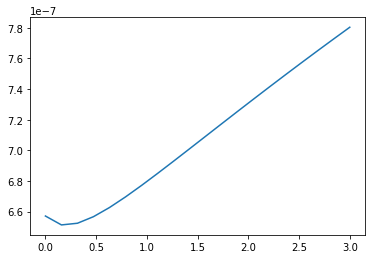

In [244]:
plt.plot(bs, sigmas.T[3])

In [252]:
b = np.ones(len(x_knots) - 6)
b[9] = 1.
b[8] = 0.25
b[7] = 0
b[6] = 0
b[5] = 0.75
b[4] = 0.5
b[3] = 0
b[2] = 0
b[1] = 1.25

bo = [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 49.99999853]

boo = [5.64774641e+00, 2.18869945e-01, 0.00000000e+00, 0.00000000e+00,
       3.89115337e-15, 1.61829882e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.80144051e+00]

In [261]:
n_par = 3

FIM = inversed_fisher_information(b0, x_knots, derivatives, KEs, dist, 1.8e-04, n_par)

sigmas = np.sqrt(np.diag(FIM))
corr = np.zeros(5)
j=0
for i in range(1 + j, 6):
    corr[i+j-1] = FIM[j][i]/(sigmas[j]*sigmas[i])
    
print(corr, sigmas)

FIM = inversed_fisher_information(boo, x_knots, derivatives, KEs, dist, 1.8e-04, n_par)

sigmas = np.sqrt(np.diag(FIM))
corr = np.zeros(5)
j=0
for i in range(1 + j, 6):
    corr[i+j-1] = FIM[j][i]/(sigmas[j]*sigmas[i])
    
print(corr, sigmas)

[ 0.31518792  0.40072003  0.30935576 -0.99850816  0.32068577] [4.36066008e+01 6.46759866e+00 3.51642897e-08 8.27267712e-07
 1.42981097e+03 3.03815522e-01]
[ 0.34966463  0.48514651  0.33578011 -0.99835677  0.35771302] [3.03509667e+01 4.77113422e+00 2.91245480e-08 6.19704487e-07
 9.92155033e+02 2.26514367e-01]


In [263]:
3.03509667e+01/m

10116.9889

In [199]:
theta = np.array([m, 1, 1, max_energy, U, lin])
popt, sigmas, corr = parameters_error_and_corr(b0, x_knots, KEs, dist, b0, theta)
popt, sigmas, corr

ValueError: lam value too large

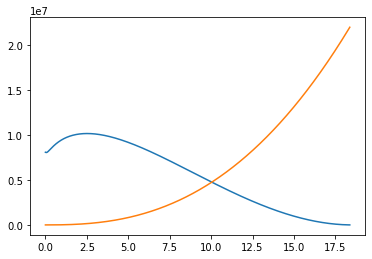

In [101]:
plt.plot(KEs, intensity(KEs, max_energy, m, U, lin))
plt.plot(KEs, experiment(KEs, *popt))

In [66]:
inversed_fisher_information(b0, x_knots, derivatives, KEs, dist)/inversed_fisher_information(bo, x_knots, derivatives, KEs, dist)

0.6975833591246634

In [41]:
bo = [3.44899946, 0.        , 0.        , 0.        , 0.        ,
       1.31942577, 1.37361597, 0.        , 0.        , 0.36451806]